In [39]:
import xarray as xr # for data handling
import numpy as np # for maths
import matplotlib as mpl # plotlibrary
import matplotlib.pyplot as plt # for the plots 
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm # for making a log 10 colorscale
import cartopy # library for making maps
from cartopy import crs as ccrs # Projection Library
from cartopy.crs import Stereographic, PlateCarree, Mollweide # Map projections I use00
from cartopy.feature import LAND, COASTLINE # Vectordata of the Coastline and land for making the maps prettier
import cmocean
from glob import glob
import dask
from scipy.io import loadmat
import gsw

# Exercise 1

## Read Files

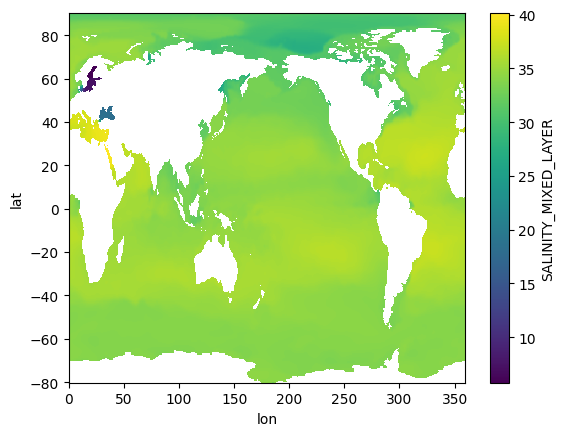

In [255]:
mimoc_files = glob("./MIMOC_ML_v2.2_PT_S/*")
mimoc = xr.open_mfdataset(mimoc_files, combine="nested", concat_dim="month", compat="no_conflicts", data_vars="different")
mimoc = mimoc.assign_coords(
    dict(
        lat=mimoc.LATITUDE,
        lon=mimoc.LONGITUDE,
    )
).swap_dims(
    dict(
        LAT="lat",
        LONG="lon",
    )
).drop_vars(("LATITUDE", "LONGITUDE")).sortby(["lon", "lat"])
mimoc.SALINITY_MIXED_LAYER.isel(month=0).plot()

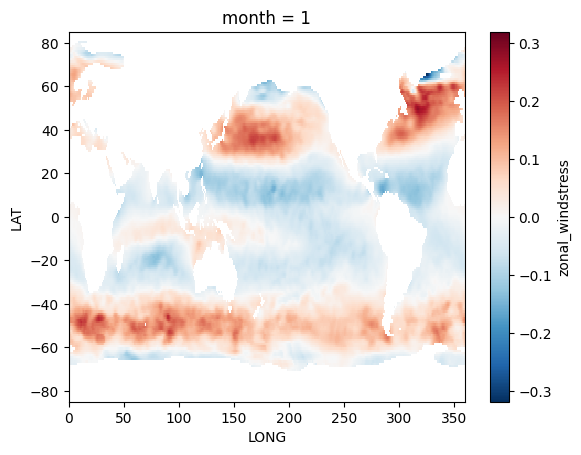

In [3]:
lats = loadmat("./atae.mat").get("lat").T[0]
lons = loadmat("./atae.mat").get("lon").T[0]
months = np.arange(1,13)
windstress = xr.Dataset(
    data_vars=dict(
        zonal_windstress=(["LAT","LONG","month"], loadmat("./atae.mat").get("atae")),
        meridional_windstress=(["LAT","LONG","month"], loadmat("./atae.mat").get("atae")),
        ),
    coords=dict(
        LAT=("LAT", lats),
        LONG=("LONG", lons),
        month=("month", months),
    ),
).sortby("LONG")
windstress.zonal_windstress.isel(month=0).plot()

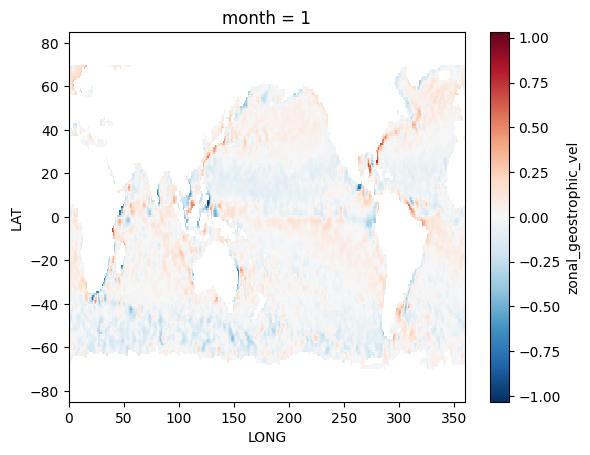

In [4]:
lats = loadmat("./Drifter_climatology.mat").get("lat").T[0]
lons = loadmat("./Drifter_climatology.mat").get("lon").T[0]
months = np.arange(1,13)
geostrophic_velovcity = xr.Dataset(
    data_vars=dict(
        zonal_geostrophic_vel=(["LAT","LONG","month"], loadmat("./Drifter_climatology.mat").get("iV_g")),
        meridional_geostrophic_vel=(["LAT","LONG","month"], loadmat("./Drifter_climatology.mat").get("iU_g")),
        ),
    coords=dict(
        LAT=("LAT", lats),
        LONG=("LONG", lons),
        month=("month", months),
    ),
).sortby("LONG")
geostrophic_velovcity.zonal_geostrophic_vel.isel(month=0).plot()

## Ekman Pumping

In [110]:
windstress["lon"] = xr.where(
    windstress["LONG"]>180, # take all the values, where X is less than zero
    windstress["LONG"]-360, # if true, add 360
    windstress["LONG"], # if false take them verbatim
)
windstress = (
    windstress
    .swap_dims({"LONG": "lon"}) # Make the new values to our dimension
    .sel(**{"lon":sorted(windstress.lon)}) # make sure to sort them
    .drop_vars("LONG") # drop the old Dimension
)

KeyError: "No variable named 'LONG'. Variables on the dataset include ['zonal_windstress', 'meridional_windstress', 'LAT', 'month', 'lon']"

In [217]:
def deg360to180(ds, lon_dim):
    dim_name = ds[lon_dim].dims[0]
    ds["lon_new"] = xr.where(
    ds[lon_dim]>180, # take all the values, where X is less than zero
    ds[lon_dim]-360, # if true, add 360
    ds[lon_dim], # if false take them verbatim
    )
    ds = (
        ds
        .swap_dims(dict(zip([dim_name], ["lon_new"]))) # Make the new values to our dimension
        .sortby("lon_new") # make sure to sort them
        .drop_vars(lon_dim) # drop the old Dimension
        .rename(dict(zip(["lon_new"],[dim_name])))
    )#
    return ds

In [244]:
deg360to180(mimoc, "longitude").compute()#.SALINITY_MIXED_LAYER.isel(month=0).plot()

<xarray.Dataset> Size: 35MB
Dimensions:                            (month: 12, lat: 341, lon: 720)
Coordinates:
  * lon                                (lon) float32 3kB -179.5 -179.0 ... 180.0
    latitude                           (lat) float32 1kB -80.0 -79.5 ... 90.0
Dimensions without coordinates: month, lat
Data variables:
    SALINITY_MIXED_LAYER               (month, lat, lon) float32 12MB 34.17 ....
    POTENTIAL_TEMPERATURE_MIXED_LAYER  (month, lat, lon) float32 12MB -0.8934...
    DEPTH_MIXED_LAYER                  (month, lat, lon) float32 12MB 40.46 ....

In [247]:
mimoc_south_atlantic = deg360to180(mimoc, "longitude").compute().sel(month=8, lon=slice(-60,30))
mimoc_south_atlantic.sel(lat=slice(1,20))

<xarray.Dataset> Size: 42kB
Dimensions:                            (lat: 19, lon: 181)
Coordinates:
  * lon                                (lon) float32 724B -60.0 -59.5 ... 30.0
    latitude                           (lat) float32 76B -79.5 -79.0 ... -70.5
Dimensions without coordinates: lat
Data variables:
    SALINITY_MIXED_LAYER               (lat, lon) float32 14kB nan nan ... nan
    POTENTIAL_TEMPERATURE_MIXED_LAYER  (lat, lon) float32 14kB nan nan ... nan
    DEPTH_MIXED_LAYER                  (lat, lon) float32 14kB nan nan ... nan

In [226]:
gsw.density.rho(mimoc_south_atlantic.SALINITY_MIXED_LAYER, mimoc_south_atlantic.POTENTIAL_TEMPERATURE_MIXED_LAYER, 0)

<xarray.DataArray 'SALINITY_MIXED_LAYER' (lat: 0, lon: 181)> Size: 0B
dask.array<rho, shape=(0, 181), dtype=float64, chunksize=(0, 181), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float32 724B -60.0 -59.5 -59.0 -58.5 ... 28.5 29.0 29.5 30.0
    latitude  (lat) float32 0B dask.array<chunksize=(0,), meta=np.ndarray>
Dimensions without coordinates: lat

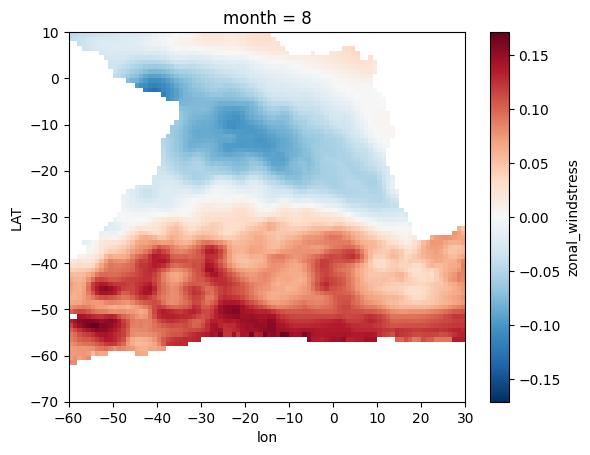

In [36]:
windstress.sel(month=8, LAT=slice(-70,10), lon=slice(-60,30)).zonal_windstress.plot()